## Introduction

This python notebook reproduces the visualizations as seen in Wu et al. (2022) and are further presented in the Master Thesis "Towards Layer-wise deep kernel learning" by Pim Schoolkate (Universidad Polytecnica de Catalunya), supervised by Lluis A. Belanche (Universidad Polytecnica de Catalunya). 


Wu, C. T., Masoomi, A., Gretton, A., & Dy, J. (2022, May). Deep Layer-wise Networks Have Closed-Form Weights. In International Conference on Artificial Intelligence and Statistics (pp. 188-225). PMLR.

In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
import sys

sys.path.append('./src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model import kchain
from data_functions import make_adversarial, make_spirals, standardize, normalize, load_complete_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

## Examples for when the data is not perfectly separable

First, some examples for when the data is not perfectly separable are presented. The first example is done using data that is generated using the make_spirals function as defined in the data_functions.py file. 
In the plots below the output z_l for each layer l is plotted in 3d. The kernel mean embeddings correspond to the points (1, 0, 0), (0, 1, 0), and (0, 0, 1) for the first, second, and third class respectively. Clearly, in the first layer some samples get mixed up, and this pattern continues in all layers. Both in the train and test data, the most samples belonging to the same class get pulled in their corresponding kernel mean embedding, however, they "drag" some samples from the other classes with them. 

This is also visible in the decision boundaries, which are plotted directly after this and follow the same logic; for each layer, the decision boundary is plotted. The first plot represents 0 layers and is simply a K-Nearest Neighbour prediction. What is problematic about these plots is that directly in the first layer, the model mixes up the outer edges of the decision boundary, predicting the wrong class for an area that is clearly far away from the points belonging to that wrongly predicted class. The points that are wrongly predicted are marked with a red cross.

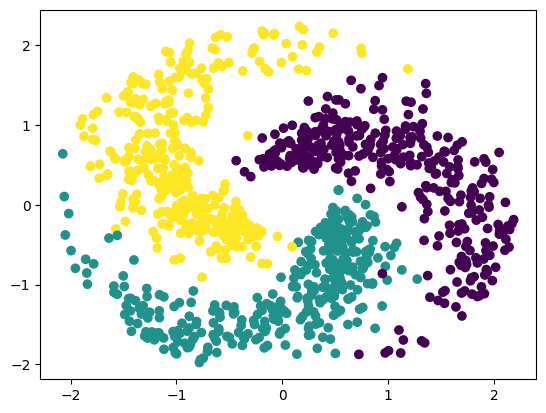

In [227]:
X, y = make_spirals(3, 1000, sep=0.2, noise=0.4, radius=1, len=2, shuffle=True)
X = standardize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [228]:
model = kchain(min_sigma=1e-5, RFF_d=200, stop_crit='hsic')
model.fit(X_train, y_train, max_layers=10, 
          X_test=X_test, y_test=y_test, 
          verbose=True)

HSIC for layer 0: 62.247 - Previous: 0.000
HSIC for layer 1: 82.259 - Previous: 62.247
HSIC for layer 2: 109.669 - Previous: 82.259
HSIC for layer 3: 123.767 - Previous: 109.669
HSIC for layer 4: 131.092 - Previous: 123.767
HSIC for layer 5: 0.676 - Previous: 131.092


<Figure size 1000x1000 with 0 Axes>

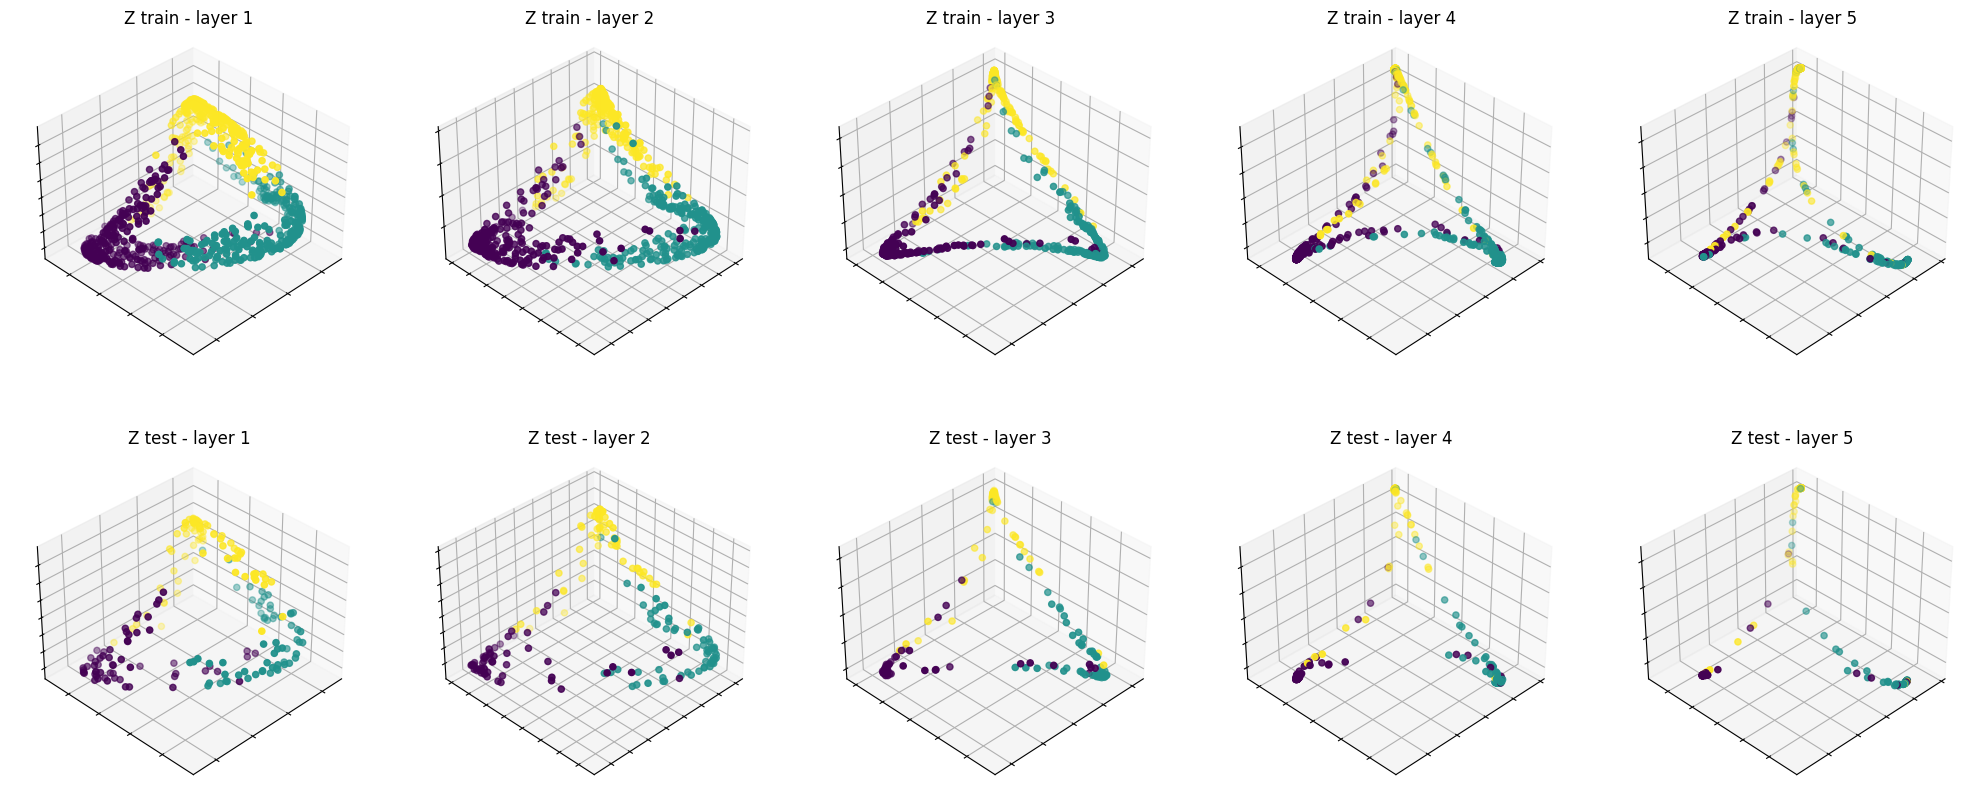

In [229]:
z = X_train
z_test = X_test

num_plots = len(model.layers)

fig = plt.figure(figsize=(10, 10))

fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 5, 10), subplot_kw={'projection': '3d'})
# fig.tight_layout()

for i, layer in enumerate(model.layers):

    # ax = fig.add_subplot(2, num_plots, i+1, projection='3d')
    ax = axs[0, i]
    z = layer.forward(z)
    ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=y_train)
    ax.view_init(35, 45, 0)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_title(f'Z train - layer {i+1}')

    # ax = fig.add_subplot(2, num_plots, i+1+num_plots, projection='3d')
    ax = axs[1, i]
    z_test = layer.forward(z_test)
    ax.scatter(z_test[:, 0], z_test[:, 1], z_test[:, 2], c=y_test)
    ax.view_init(35, 45, 0)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.set_title(f'Z test - layer {i+1}')

fig.savefig('figures/bad_spirals.jpeg')

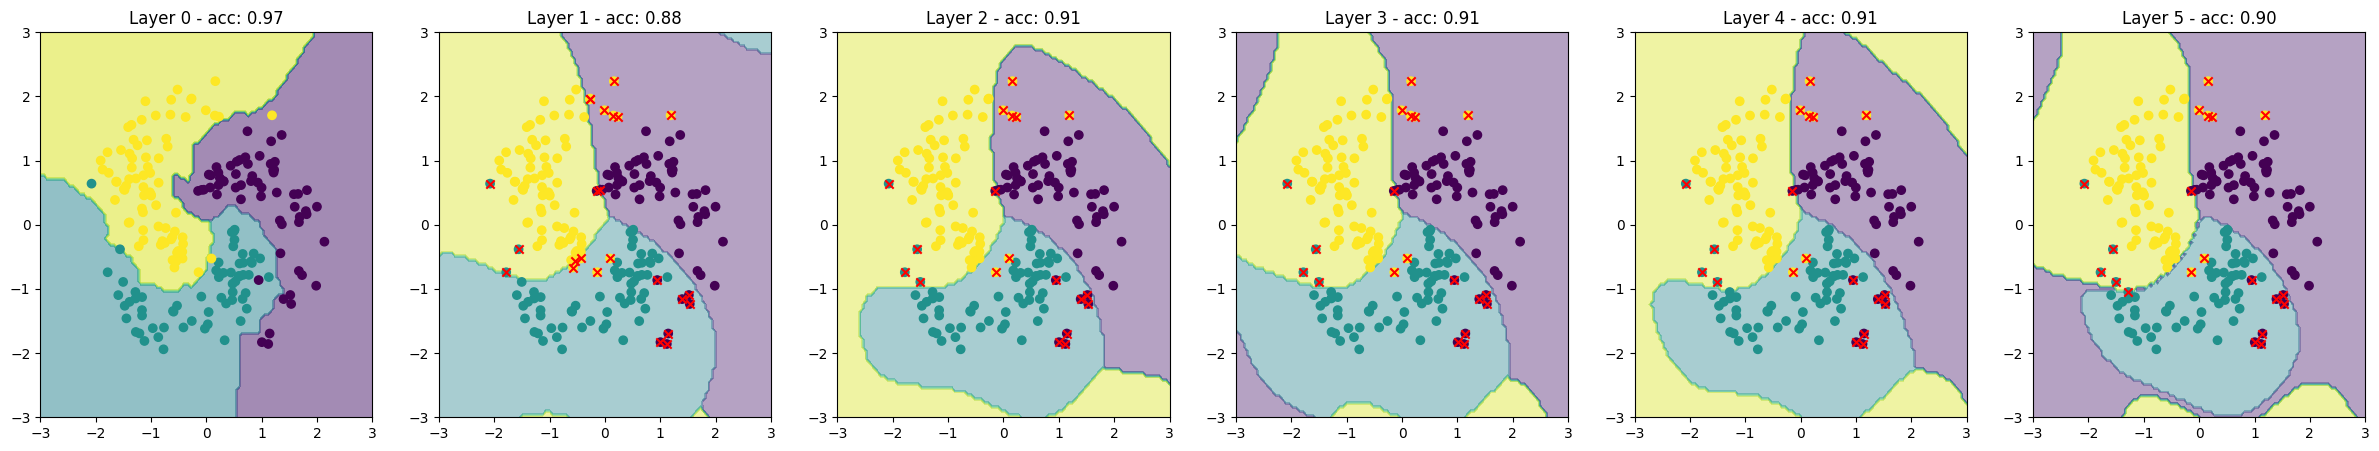

In [230]:
grid1 = np.linspace(-3, 3, 100)
grid2 = np.linspace(-3, 3, 100)

x1, x2 = np.meshgrid(grid1, grid2)

z = np.array([x1.ravel(), x2.ravel()]).T
z_test = X_test

n_plots = len(model.layers) + 1

plt.figure(figsize=(n_plots * 5, 5))

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_hat = knn.predict(z)
plt.subplot(1, n_plots, 1)
plt.contourf(x1, x2, y_hat.reshape(x1.shape), alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)


acc = accuracy_score(y_test, knn.predict(X_test))
plt.title(f"Layer 0 - acc: {acc:.2f}")

for i, layer in enumerate(model.layers):
    z = layer.forward(z)
    y_hat_l = z.argmax(axis=1)
    plt.subplot(1, n_plots, i+2)
    plt.contourf(x1, x2, y_hat_l.reshape(x1.shape), alpha=0.4)
    # plt.scatter(x1.ravel(), x2.ravel(), c=y_hat_l, alpha=0.05)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)


    z_test = layer.forward(z_test)
    y_hat_l = z_test.argmax(axis=1)
    wrong_pred_X = X_test[y_test != y_hat_l]
    wrong_pred_y = y_test[y_test != y_hat_l]

    plt.scatter(wrong_pred_X[:, 0], wrong_pred_X[:, 1], c='red', marker='x')

    acc = accuracy_score(y_test, y_hat_l)
    plt.title(f"Layer {i+1} - acc: {acc:.2f}")

plt.savefig('figures/bad_spirals_decision_boundaries.jpeg')

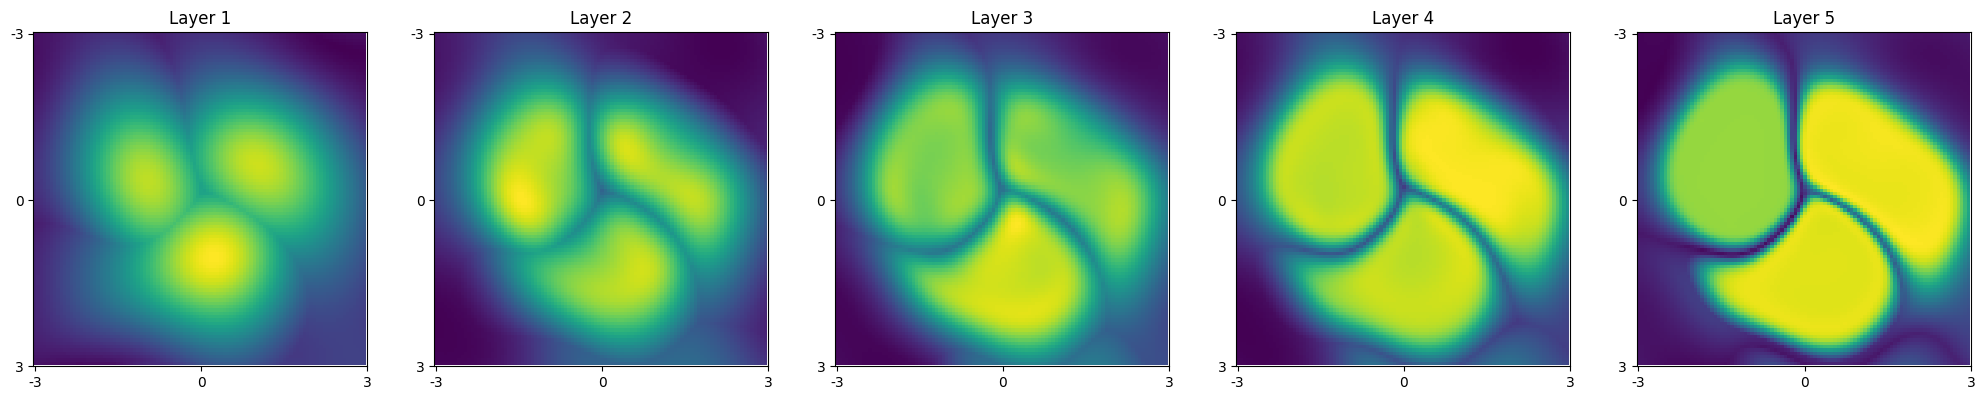

In [231]:
grid1 = np.linspace(-3, 3, 100)
grid2 = np.linspace(-3, 3, 100)

x1, x2 = np.meshgrid(grid1, grid2)

z = np.array([x1.ravel(), x2.ravel()]).T

plt.figure(figsize=(25, 5))

for i, layer in enumerate(model.layers):
    z = layer.forward(z)

    plt.subplot(1, n_plots-1, i+1)
    plt.imshow(np.rot90(z.max(axis=1).reshape(100, 100).T))
    plt.xticks([0, 50, 100], [-3, 0, 3])
    plt.yticks([0, 50, 100], [-3, 0, 3])

    plt.title(f"Layer {i+1}")

plt.savefig('figures/bad_spirals_confidence_map.jpeg')

### Comparing to a MLP classifier

To compare the decision boundary of the kchain model, a MLP classifier is trained on the same train set and tested on the same test set. Clearly, the MLP is able to generalize better, as not only it is able to correctly predict the test set, it also properly sets the decision boundaries, not predicting the wrong class in far edges. 

In [208]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4,
                    solver='adam', verbose=False, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train.ravel())

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate_init=0.1,
              max_iter=1000, random_state=1)

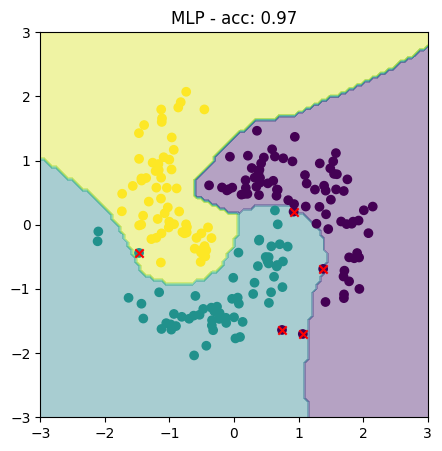

In [209]:
grid1 = np.linspace(-3, 3, 100)
grid2 = np.linspace(-3, 3, 100)

x1, x2 = np.meshgrid(grid1, grid2)

z = np.array([x1.ravel(), x2.ravel()]).T

y_hat = mlp.predict(z)

plt.figure(figsize=(5, 5))

plt.contourf(x1, x2, y_hat.reshape(x1.shape), alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

y_hat = mlp.predict(X_test)
wrong_pred_X = X_test[y_test != y_hat]
wrong_pred_y = y_test[y_test != y_hat]
plt.scatter(wrong_pred_X[:, 0], wrong_pred_X[:, 1], c='red', marker='x')

acc = accuracy_score(y_test, y_hat)

plt.title(f"MLP - acc: {acc:.2f}")

plt.savefig('figures/bad_spirals_mlp.jpeg')

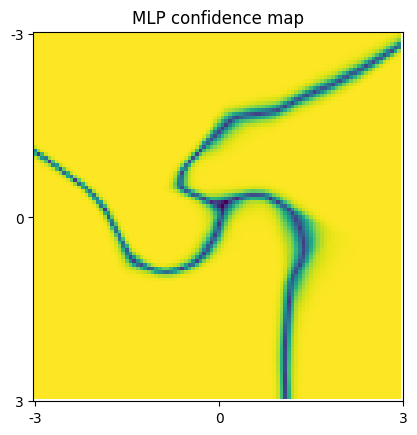

In [219]:
plt.imshow(np.rot90(mlp.predict_proba(z).max(axis=1).reshape(100, 100).T))
plt.xticks([0, 50, 100], [-3, 0, 3])
plt.yticks([0, 50, 100], [-3, 0, 3])
plt.title(f"MLP confidence map")

plt.savefig('figures/bad_spirals_mlp_confidence_map.jpeg')

## Recreating the figure in the paper by Wu et al. (2022)

Wu et al. (2022) present a figure which illustrates how all points of the same class gravitate towards their corresponding kernel mean embedding. The method is exactly the same as the plots above, however, the data is now generated to approximately match that of Wu et al. (2022) (which was done by visual confirmation and is not entirely precise). Compared to the one above, this problem is much more easier, and thus, the kchain is able to properly separate the data. For this reasons, it seems that the visualization done by Wu et al. (2022) is not entirely representative of the problem they are trying to solve, and might infact be cherry-picking to support their own claims.

However, even for this problem, the decision boundaries are extremely undesirable. The first layer already mixes up the outer edges of the decision boundary, and this pattern continues in all layers.

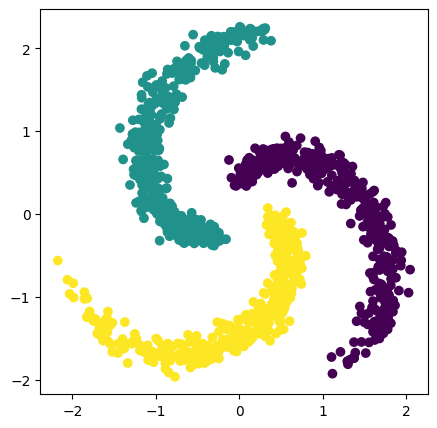

In [143]:
from sklearn.preprocessing import LabelEncoder

X, y = load_complete_data('spiral')
X = standardize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)

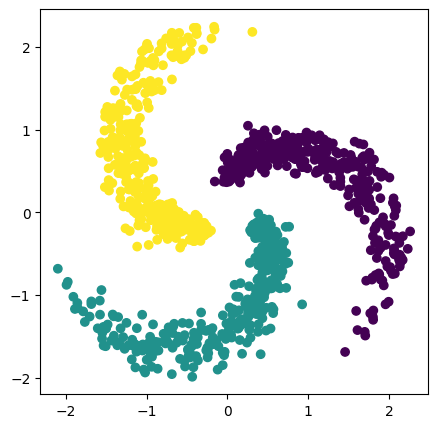

In [128]:
# X, y = make_spirals(3, 1000, sep=0.6, noise=0.2, radius=4, len=2, shuffle=True)
# X = standardize(X)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# plt.figure(figsize=(5, 5))
# plt.scatter(X[:, 0], X[:, 1], c=y)

In [144]:
model = kchain(min_sigma=1e-5, RFF_d=200, stop_crit='hsic')
model.fit(X_train, y_train, max_layers=10, 
          X_test=X_test, y_test=y_test, 
          verbose=True)

HSIC for layer 0: 74.371 - Previous: 0.000
HSIC for layer 1: 98.994 - Previous: 74.371
HSIC for layer 2: 142.386 - Previous: 98.994
HSIC for layer 3: 160.671 - Previous: 142.386
HSIC for layer 4: 170.277 - Previous: 160.671
HSIC for layer 5: 0.748 - Previous: 170.277


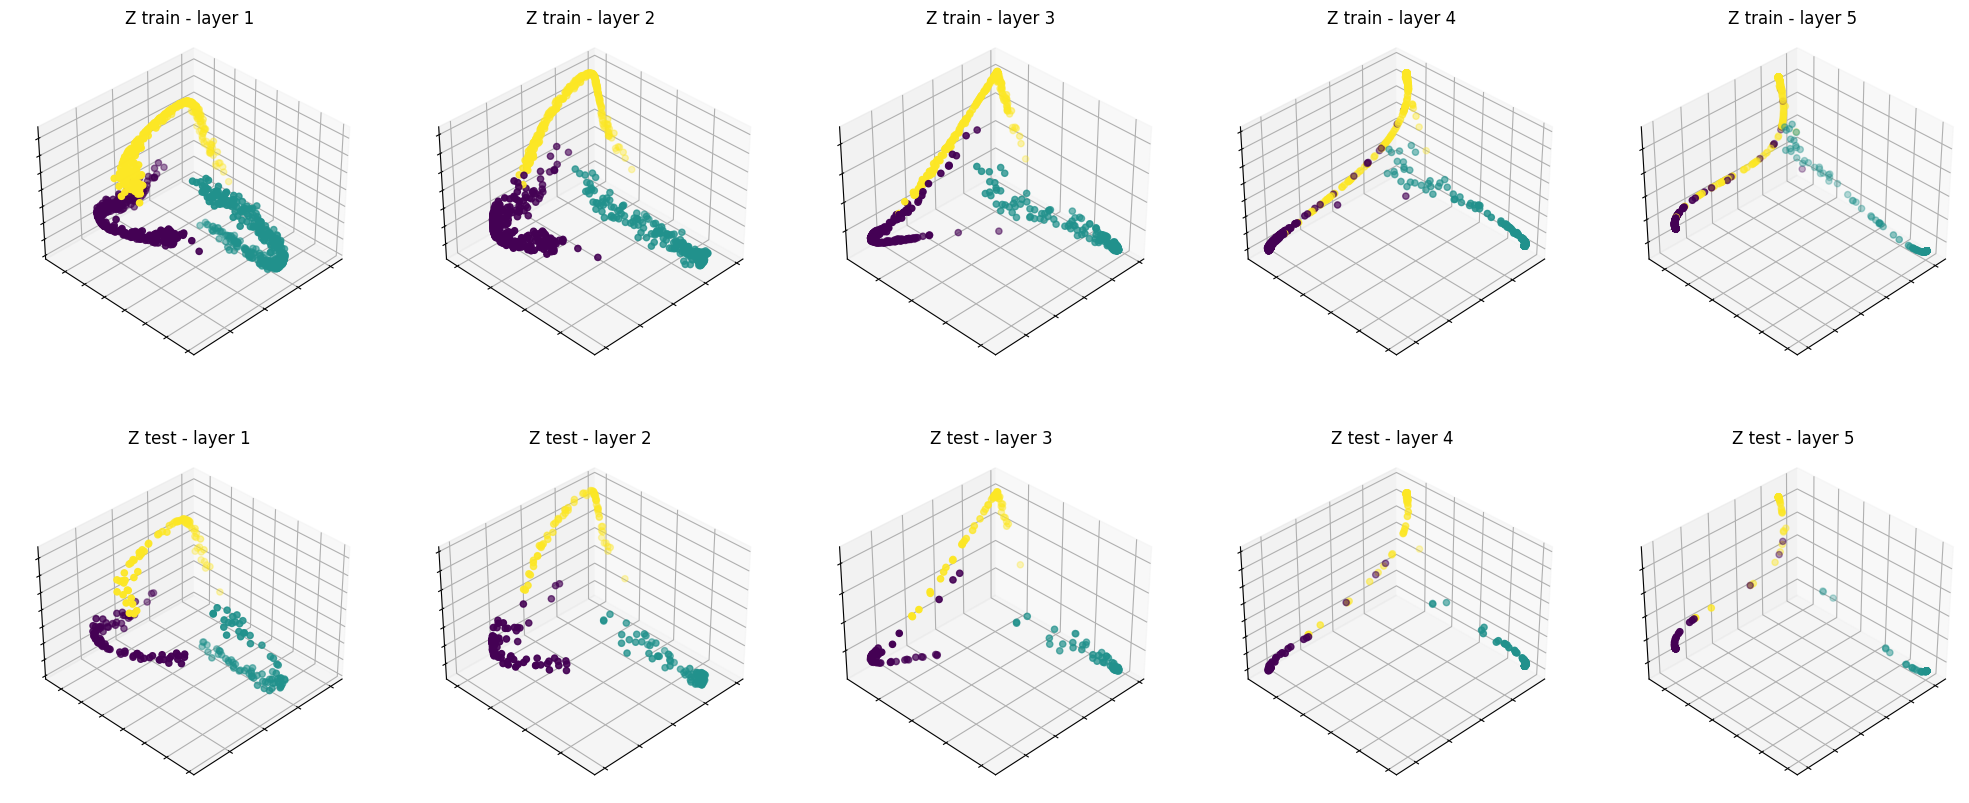

In [201]:
z = X_train
z_test = X_test

num_plots = len(model.layers)

fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 5, 10), subplot_kw={'projection': '3d'})

for i, layer in enumerate(model.layers):

    # ax = fig.add_subplot(2, num_plots, i+1, projection='3d')
    ax = axs[0, i]
    z = layer.forward(z)
    ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=y_train)
    ax.view_init(35, 45, 0)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_title(f'Z train - layer {i+1}')

    # ax = fig.add_subplot(2, num_plots, i+1+num_plots, projection='3d')
    ax = axs[1, i]
    z_test = layer.forward(z_test)
    ax.scatter(z_test[:, 0], z_test[:, 1], z_test[:, 2], c=y_test)
    ax.view_init(35, 45, 0)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.set_title(f'Z test - layer {i+1}')

fig.savefig('figures/good_spirals.jpeg')

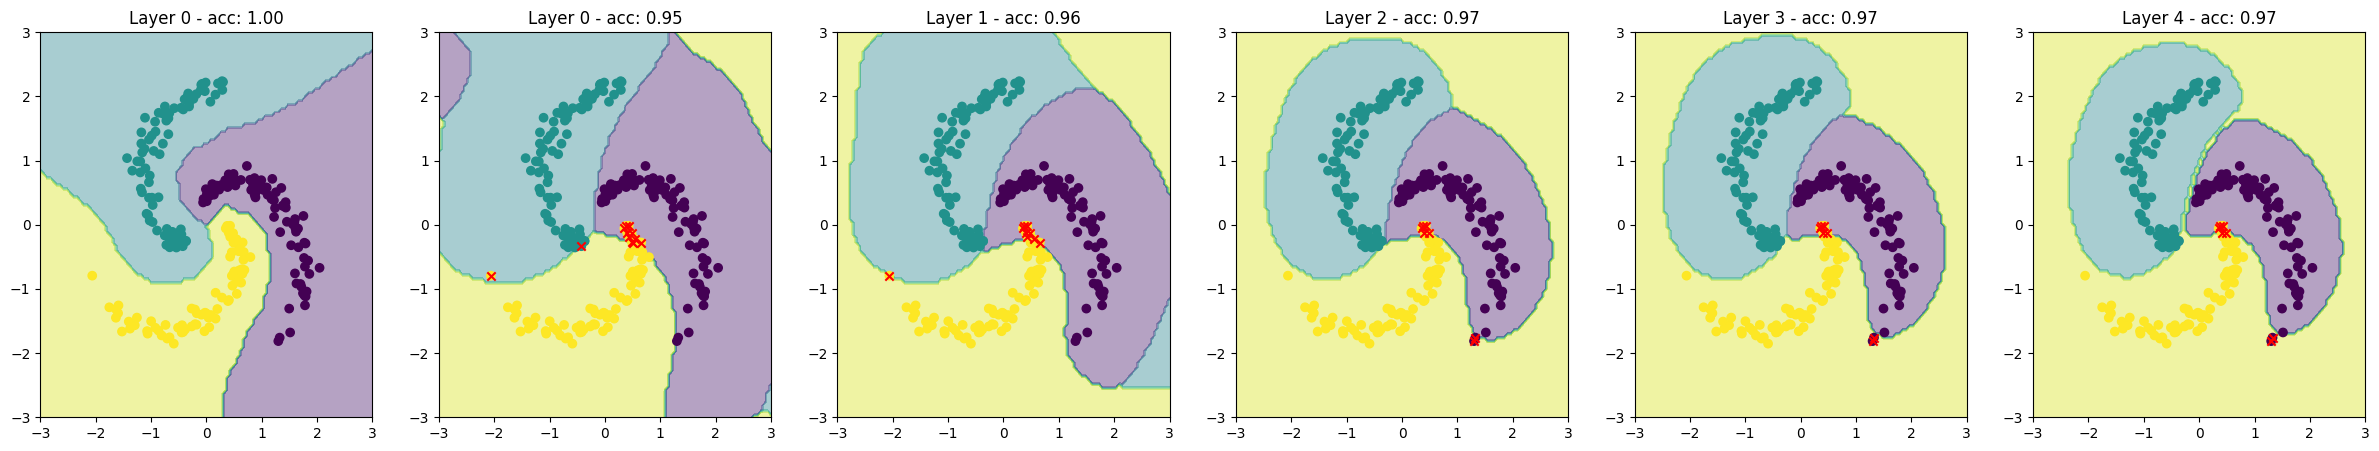

In [199]:
grid1 = np.linspace(-3, 3, 100)
grid2 = np.linspace(-3, 3, 100)

x1, x2 = np.meshgrid(grid1, grid2)

z = np.array([x1.ravel(), x2.ravel()]).T
z_test = X_test

n_plots = len(model.layers) + 1

plt.figure(figsize=(n_plots * 5, 5))

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_hat = knn.predict(z)
plt.subplot(1, n_plots, 1)
plt.contourf(x1, x2, y_hat.reshape(x1.shape), alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

acc = accuracy_score(y_test, knn.predict(X_test))
plt.title(f"Layer 0 - acc: {acc:.2f}")

for i, layer in enumerate(model.layers):
    z = layer.forward(z)
    y_hat_l = z.argmax(axis=1)
    plt.subplot(1, n_plots, i+2)
    plt.contourf(x1, x2, y_hat_l.reshape(x1.shape), alpha=0.4)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

    z_test = layer.forward(z_test)
    y_hat_l = z_test.argmax(axis=1)
    wrong_pred_X = X_test[y_test != y_hat_l]
    wrong_pred_y = y_test[y_test != y_hat_l]

    plt.scatter(wrong_pred_X[:, 0], wrong_pred_X[:, 1], c='red', marker='x')

    acc = accuracy_score(y_test, y_hat_l)
    plt.title(f"Layer {i} - acc: {acc:.2f}")

plt.savefig('figures/good_spirals_decision_boundaries.jpeg')

# y_hat = model.forward(np.array([x1.ravel(), x2.ravel()]).T, n=0).argmax(axis=1)

# plt.scatter(x1.ravel(), x2.ravel(), c=y_hat, alpha=0.1)

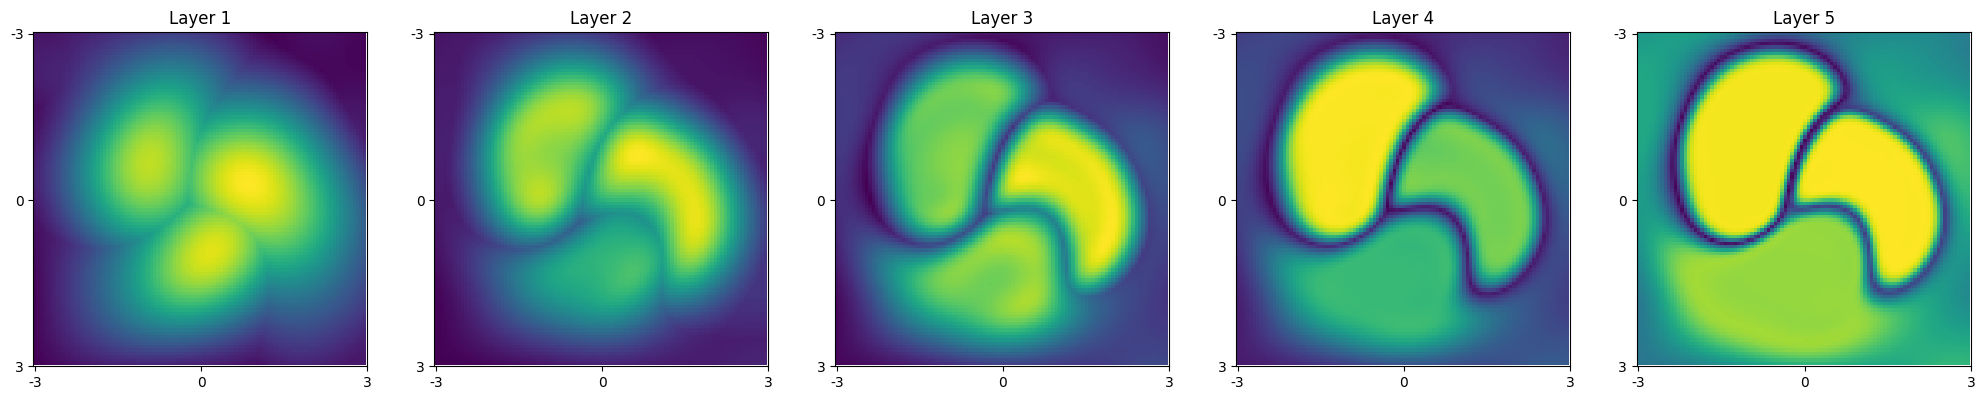

In [198]:
grid1 = np.linspace(-3, 3, 100)
grid2 = np.linspace(-3, 3, 100)

x1, x2 = np.meshgrid(grid1, grid2)

z = np.array([x1.ravel(), x2.ravel()]).T

plt.figure(figsize=(25, 5))

for i, layer in enumerate(model.layers):
    z = layer.forward(z)

    plt.subplot(1, n_plots-1, i+1)
    plt.imshow(np.rot90(z.max(axis=1).reshape(100, 100).T))
    plt.xticks([0, 50, 100], [-3, 0, 3])
    plt.yticks([0, 50, 100], [-3, 0, 3])

    plt.title(f"Layer {i+1}")

plt.savefig('figures/good_spirals_confidence_map.jpeg')

0.05636539273873367

## An analysis on the adversarial examples

Unfortunately, the adversarial data visualizations were not able to be reproduced. It was found that the kernel mean embedding for the first layer does indeed help with separating the train data, but for the test data, this is not meaningful. One can see that the test accuracy improves, which might suggest the model working well. However, for a more indepth analysis on these results, see the cross_validation_experiments.ipynb file.

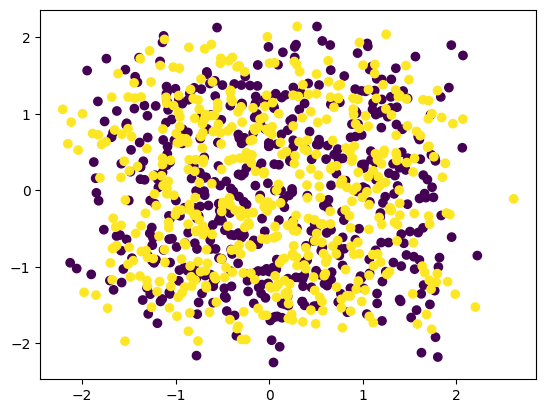

In [113]:
X, y = make_adversarial(1000, 0.1)
X = standardize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [114]:
model = kchain(min_sigma=1e-5, RFF_d=200, stop_crit='hsic')
model.fit(X_train, y_train, max_layers=10, 
          X_test=X_test, y_test=y_test, 
          verbose=True)

HSIC for layer 0: 0.509 - Previous: 0.000
HSIC for layer 1: 10.386 - Previous: 0.509
HSIC for layer 2: 0.500 - Previous: 10.386


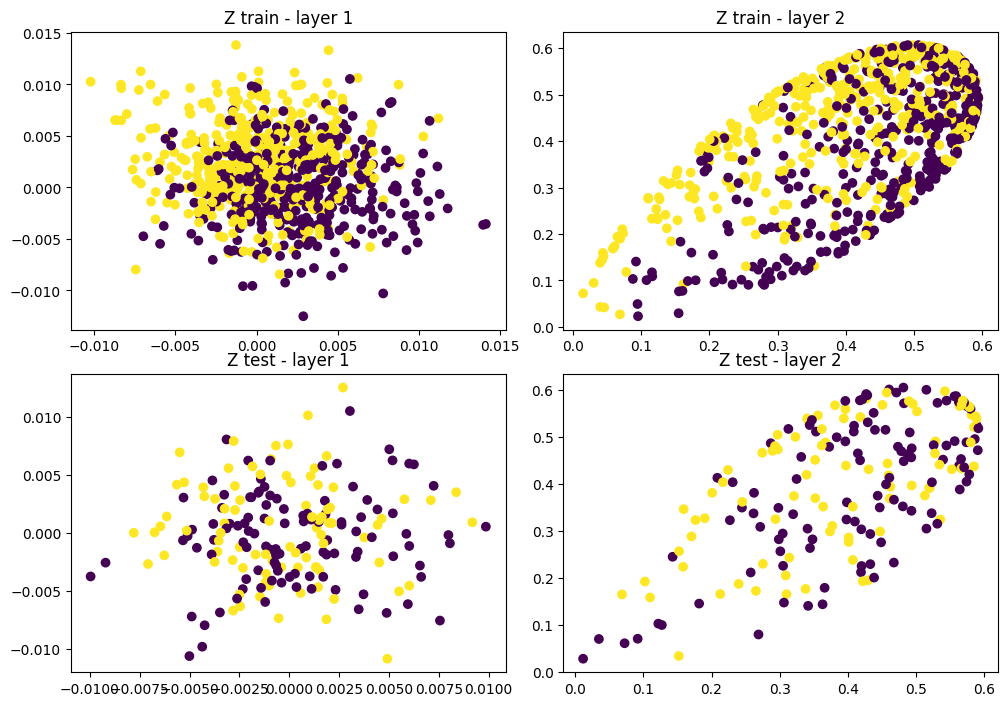

In [115]:
z = X_train
z_test = X_test

num_plots = len(model.layers)

fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 5, 7))
fig.tight_layout()

for i, layer in enumerate(model.layers):

    # ax = fig.add_subplot(2, num_plots, i+1, projection='3d')
    ax = axs[0, i]
    z = layer.forward(z)
    ax.scatter(z[:, 0], z[:, 1], c=y_train)
    ax.set_title(f'Z train - layer {i+1}')

    # ax = fig.add_subplot(2, num_plots, i+1+num_plots, projection='3d')
    ax = axs[1, i]
    z_test = layer.forward(z_test)
    ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test)

    ax.set_title(f'Z test - layer {i+1}')

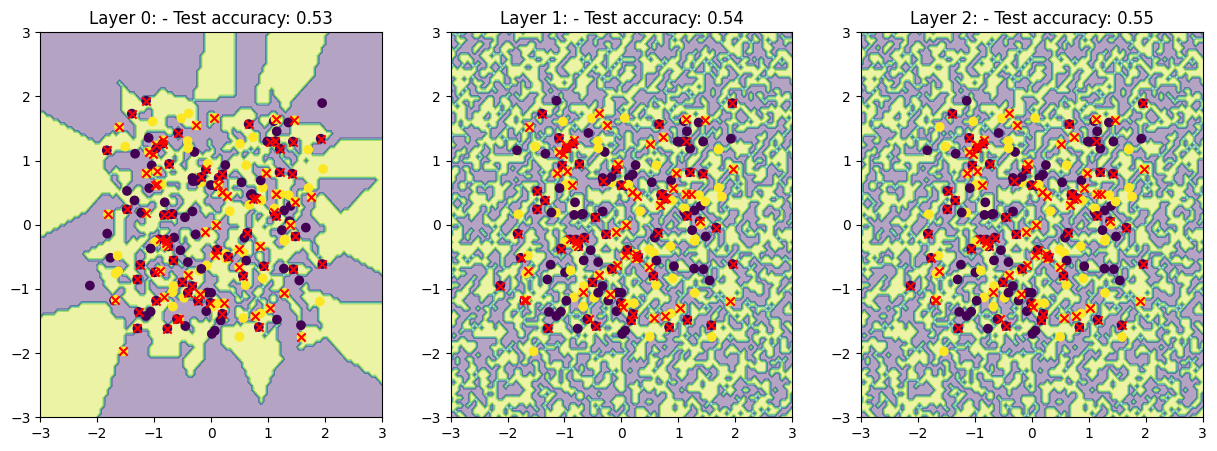

In [117]:
grid1 = np.linspace(-3, 3, 100)
grid2 = np.linspace(-3, 3, 100)

x1, x2 = np.meshgrid(grid1, grid2)

z = np.array([x1.ravel(), x2.ravel()]).T
z_test = X_test

n_plots = len(model.layers) + 1

plt.figure(figsize=(n_plots * 5, 5))


knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_hat = knn.predict(z)
plt.subplot(1, n_plots, 1)
plt.contourf(x1, x2, y_hat.reshape(x1.shape), alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

y_hat = knn.predict(z_test)
acc = accuracy_score(y_test, y_hat)
wrong_pred_X = X_test[y_test.ravel() != y_hat]
wrong_pred_y = y_test[y_test.ravel() != y_hat]
plt.scatter(wrong_pred_X[:, 0], wrong_pred_X[:, 1], c='red', marker='x')
plt.title(f"Layer 0: - Test accuracy: {acc:.2f}")

for i, layer in enumerate(model.layers):
    z = layer.forward(z)
    y_hat_l = z.argmax(axis=1)
    plt.subplot(1, n_plots, i+2)
    plt.contourf(x1, x2, y_hat_l.reshape(x1.shape), alpha=0.4)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

    z_test = layer.forward(z_test)
    y_hat_l = z_test.argmax(axis=1)
    wrong_pred_mask = y_test.ravel() != y_hat_l
    wrong_pred_X = X_test[wrong_pred_mask, :]
    wrong_pred_y = y_test[wrong_pred_mask]

    plt.scatter(wrong_pred_X[:, 0], wrong_pred_X[:, 1], c='red', marker='x')
    acc = accuracy_score(y_test, y_hat_l)
    plt.title(f"Layer {i+1}: - Test accuracy: {acc:.2f}")
    

# y_hat = model.forward(np.array([x1.ravel(), x2.ravel()]).T, n=0).argmax(axis=1)
